In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Bidirectional, LSTM, ConvLSTM2D, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

In [ ]:
!unzip "/content/drive/MyDrive/dataset/data_kecil.zip" -d "/content/dataset"

Archive:  /content/drive/MyDrive/dataset/data_kecil.zip
   creating: /content/dataset/data_kecil/
   creating: /content/dataset/data_kecil/COVID/
  inflating: /content/dataset/data_kecil/COVID/COVID-1.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-10.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-100.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1000.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1001.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1002.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1003.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1004.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1005.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1006.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1007.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1008.png  
  inflating: /content/dataset/data_kecil/COVID/COVID-1009.png  
  inflating: /content/datase

In [ ]:
data_dir = '/content/dataset'
img_height = 224
img_width = 224
batch_size=16

train_datagen = ImageDataGenerator(
    #  rotation_range=30, 
    #  width_shift_range=0.2,
    #  height_shift_range=0.2, 
    #  brightness_range=[0.5,1.5],  
    #  zoom_range=0.2,
    #  horizontal_flip=True, 
    rescale=1/255,
    preprocessing_function=None, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None
)

train_gen=train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_gen=train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

Found 3228 images belonging to 1 classes.
Found 807 images belonging to 1 classes.


#Build Arsitektur

##VGG19

In [ ]:
model_vgg = Sequential(VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='tanh'))
model_vgg.add(Dropout(rate=0.2))
model_vgg.add(Dense(3, activation='softmax'))
tf.keras.applications.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


##VGG19 + BiLSTM

In [ ]:
model_vggbilstm = Sequential(VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_vggbilstm.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_vggbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_vggbilstm.add(Dropout(0.5))
model_vggbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_vggbilstm.add(Dropout(0.5))
model_vggbilstm.add(Dense(128, activation='tanh'))
model_vggbilstm.add(Dropout(0.5))
model_vggbilstm.add(Dense(3, activation='softmax'))

## ResNET50

In [ ]:
model_resnet = Sequential(ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_resnet.add(Flatten())
model_resnet.add(Dense(512*2, activation='tanh'))
model_resnet.add(Dropout(rate=0.5))
model_resnet.add(Dense(3, activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step


## ResNet50+BiLSTM

In [ ]:
model_resnetbilstm = Sequential(ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_resnetbilstm.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_resnetbilstm.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Dense(128, activation='tanh'))
model_resnetbilstm.add(Dropout(0.5))
model_resnetbilstm.add(Dense(3, activation='softmax'))

##InceptionV3+BiLSTM

In [ ]:
model_inception = Sequential(InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_inception.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_inception.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_inception.add(Dropout(0.5))
model_inception.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(128, activation='tanh'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(3, activation='softmax'))

##XCeption+BiLSTM

In [ ]:
model_xception = Sequential(Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model_xception.add(TimeDistributed(Flatten()))
tf.keras.applications.trainable = False
model_xception.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_xception.add(Dropout(0.5))
model_xception.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(128, activation='tanh'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(3, activation='softmax'))

##Alexnet+BiLSTM

In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224, 224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(TimeDistributed(Flatten()))

#Layer BiLSTM
tf.keras.applications.trainable = False
AlexNet.add(Bidirectional(LSTM(units=128, return_sequences=True)))
AlexNet.add(Dropout(0.5))
AlexNet.add(Bidirectional(LSTM(units=128, return_sequences=False)))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(128, activation='tanh'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(3, activation='softmax'))

In [ ]:
AlexNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_6 (Batc  (None, 56, 56, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 256)     

#Training Part

In [ ]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23,236,163
Trainable params: 23,236,163
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 model_vgg.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_vgg.fit(train_gen,
                    steps_per_epoch = train_gen.samples // batch_size,
                    epochs=10, 
                    verbose=1, 
                    validation_data=valid_gen,
                    validation_steps = valid_gen.samples // batch_size)

Epoch 1/10
201/201 [==============================] - 73s 288ms/step - loss: 3.6528 - accuracy: 0.3303 - val_loss: 3.2977 - val_accuracy: 0.0000e+00
Epoch 2/10
 37/201 [====>.........................] - ETA: 42s - loss: 3.5710 - accuracy: 0.3226

KeyboardInterrupt: ignored

In [ ]:
model_vggbilstm.evaluate(valid_gen)

190/190 [==============================] - 19s 98ms/step - loss: 0.0758 - accuracy: 0.9782


[0.07577350735664368, 0.9782178401947021]

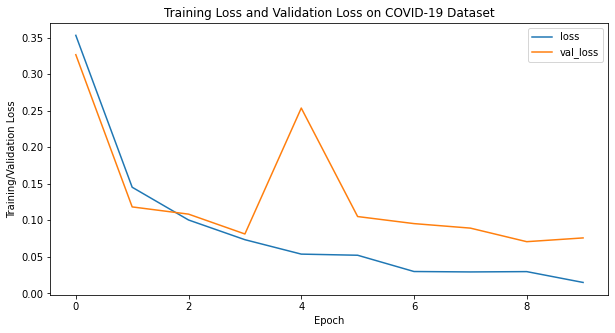

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

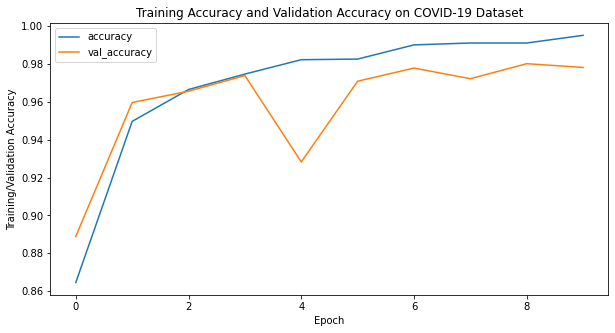

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

In [ ]:
output_class = 3
target_names = ['COVID','Normal','Viral Pneumonia']

predict = model_vggbilstm.predict(valid_gen)
classes_x=np.argmax(predict,axis=1)

print("Confusion Matrix")
cm = confusion_matrix(valid_gen.classes, classes_x)
print(cm)
    
# show the accuracy, sensitivity, and specificity  
total = sum(sum(cm))  
if output_class == 2:
    acc = (cm[0][0] + cm[1][1]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
elif output_class == 3:
    acc = (cm[0][0] + cm[1][1] + cm[2][2]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
    sensitivity = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print("{} sensitivity: {:.4f}".format(target_names[2], sensitivity))
elif output_class == 4:
    acc = (cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2] + cm[0][3])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2] + cm[1][3])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
    sensitivity = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2] + cm[2][3])
    print("{} sensitivity: {:.4f}".format(target_names[2], sensitivity))
    sensitivity = cm[3][3] / (cm[3][0] + cm[3][1] + cm[3][2] + cm[3][3])
    print("{} sensitivity: {:.4f}".format(target_names[3], sensitivity))
else:
    print("Undefined")

print("Classification Report")
if output_class == 2:
    print(classification_report(valid_gen.classes, classes_x, target_names = target_names))
elif output_class == 3:
    print(classification_report(valid_gen.classes, classes_x, target_names = target_names))
elif output_class == 4:
    print(classification_report(valid_gen.classes, classes_x, target_names = target_names))
else:
    print("Undefined")

Confusion Matrix
[[ 688   34    1]
 [  13 2013   12]
 [   0    6  263]]
acc: 0.9782
COVID sensitivity: 0.9516
Normal sensitivity: 0.9877
Viral Pneumonia sensitivity: 0.9777
Classification Report
                 precision    recall  f1-score   support

          COVID       0.98      0.95      0.97       723
         Normal       0.98      0.99      0.98      2038
Viral Pneumonia       0.95      0.98      0.97       269

       accuracy                           0.98      3030
      macro avg       0.97      0.97      0.97      3030
   weighted avg       0.98      0.98      0.98      3030



#Simpan Model

In [ ]:
model_vggbilstm.save('/content/drive/MyDrive/model/model_vgg.h5')

In [ ]:
model_resnetbilstm.save('/content/drive/MyDrive/model/model_resnet.h5')

In [ ]:
model_inception.save('/content/drive/MyDrive/model/model_inception.h5')

In [ ]:
model_xception.save('/content/drive/MyDrive/model/model_xception.h5')